# Keterangan Tugas

Film Junky Union, sebuah komunitas baru bagi penggemar film klasik sedang mengembangkan sistem untuk memfilter dan mengkategorikan ulasan film. Tujuannya adalah untuk melatih model agar bisa mendeteksi ulasan negatif secara otomatis. Anda akan menggunakan dataset ulasan film IMBD dengan pelabelan polaritas untuk membuat model yang bisa mengklasifikasikan ulasan positif dan negatif. Model ini setidaknya memiliki skor F1 0,85.

## Inisialisasi

In [1]:
import math

import numpy as np
import pandas as pd
import torch
import transformers
import spacy
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from tqdm.auto import tqdm

In [2]:
%matplotlib inline
%config InlineBackend.figure_format = 'png'
# baris berikutnya menyediakan grafik dengan kualitas yang lebih baik di layar HiDPI 

%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

In [3]:
# ini untuk menggunakan progress_apply, baca lebih lanjut di https://pypi.org/project/tqdm/#pandas-integration
tqdm.pandas()

## Memuat data

In [4]:
df_reviews = pd.read_csv("D:\Other\imdb_reviews.tsv", sep='\t', dtype={'votes': 'Int64'})

In [5]:
df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 47331 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47331 non-null  object 
 1   title_type       47331 non-null  object 
 2   primary_title    47331 non-null  object 
 3   original_title   47331 non-null  object 
 4   start_year       47331 non-null  int64  
 5   end_year         47331 non-null  object 
 6   runtime_minutes  47331 non-null  object 
 7   is_adult         47331 non-null  int64  
 8   genres           47331 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47331 non-null  object 
 12  rating           47331 non-null  int64  
 13  sp               47331 non-null  object 
 14  pos              47331 non-null  int64  
 15  ds_part          47331 non-null  object 
 16  idx              47331 non-null  int64  
dtypes: Int64(1),

In [6]:
df_reviews.loc[df_reviews['average_rating'].isna()]

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


In [7]:
df_reviews.loc[df_reviews['original_title']=='Mila Ass Painting']

,tconst,title_type,primary_title,original_title,start_year,end_year,runtime_minutes,is_adult,genres,average_rating,votes,review,rating,sp,pos,ds_part,idx
22280,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"This is a truly great film, with excellent dir...",9,pos,1,test,3231
22281,tt0192317,movie,Mila Ass Painting,Mila Ass Painting,1998,\N,\N,0,\N,NaN,<NA>,"A film is beyond all expectations, an excellen...",10,pos,1,test,3232


Tidak ada referensi untuk mengisi data kosong, sehingga baris ini akan didrop.

In [8]:
df_reviews.dropna(inplace=True)

In [9]:
df_reviews.dropna(inplace=True)

df_reviews.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47329 entries, 0 to 47330
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   tconst           47329 non-null  object 
 1   title_type       47329 non-null  object 
 2   primary_title    47329 non-null  object 
 3   original_title   47329 non-null  object 
 4   start_year       47329 non-null  int64  
 5   end_year         47329 non-null  object 
 6   runtime_minutes  47329 non-null  object 
 7   is_adult         47329 non-null  int64  
 8   genres           47329 non-null  object 
 9   average_rating   47329 non-null  float64
 10  votes            47329 non-null  Int64  
 11  review           47329 non-null  object 
 12  rating           47329 non-null  int64  
 13  sp               47329 non-null  object 
 14  pos              47329 non-null  int64  
 15  ds_part          47329 non-null  object 
 16  idx              47329 non-null  int64  
dtypes: Int64(1),

## EDA

Periksa jumlah film dan ulasan selama bertahun-tahun.

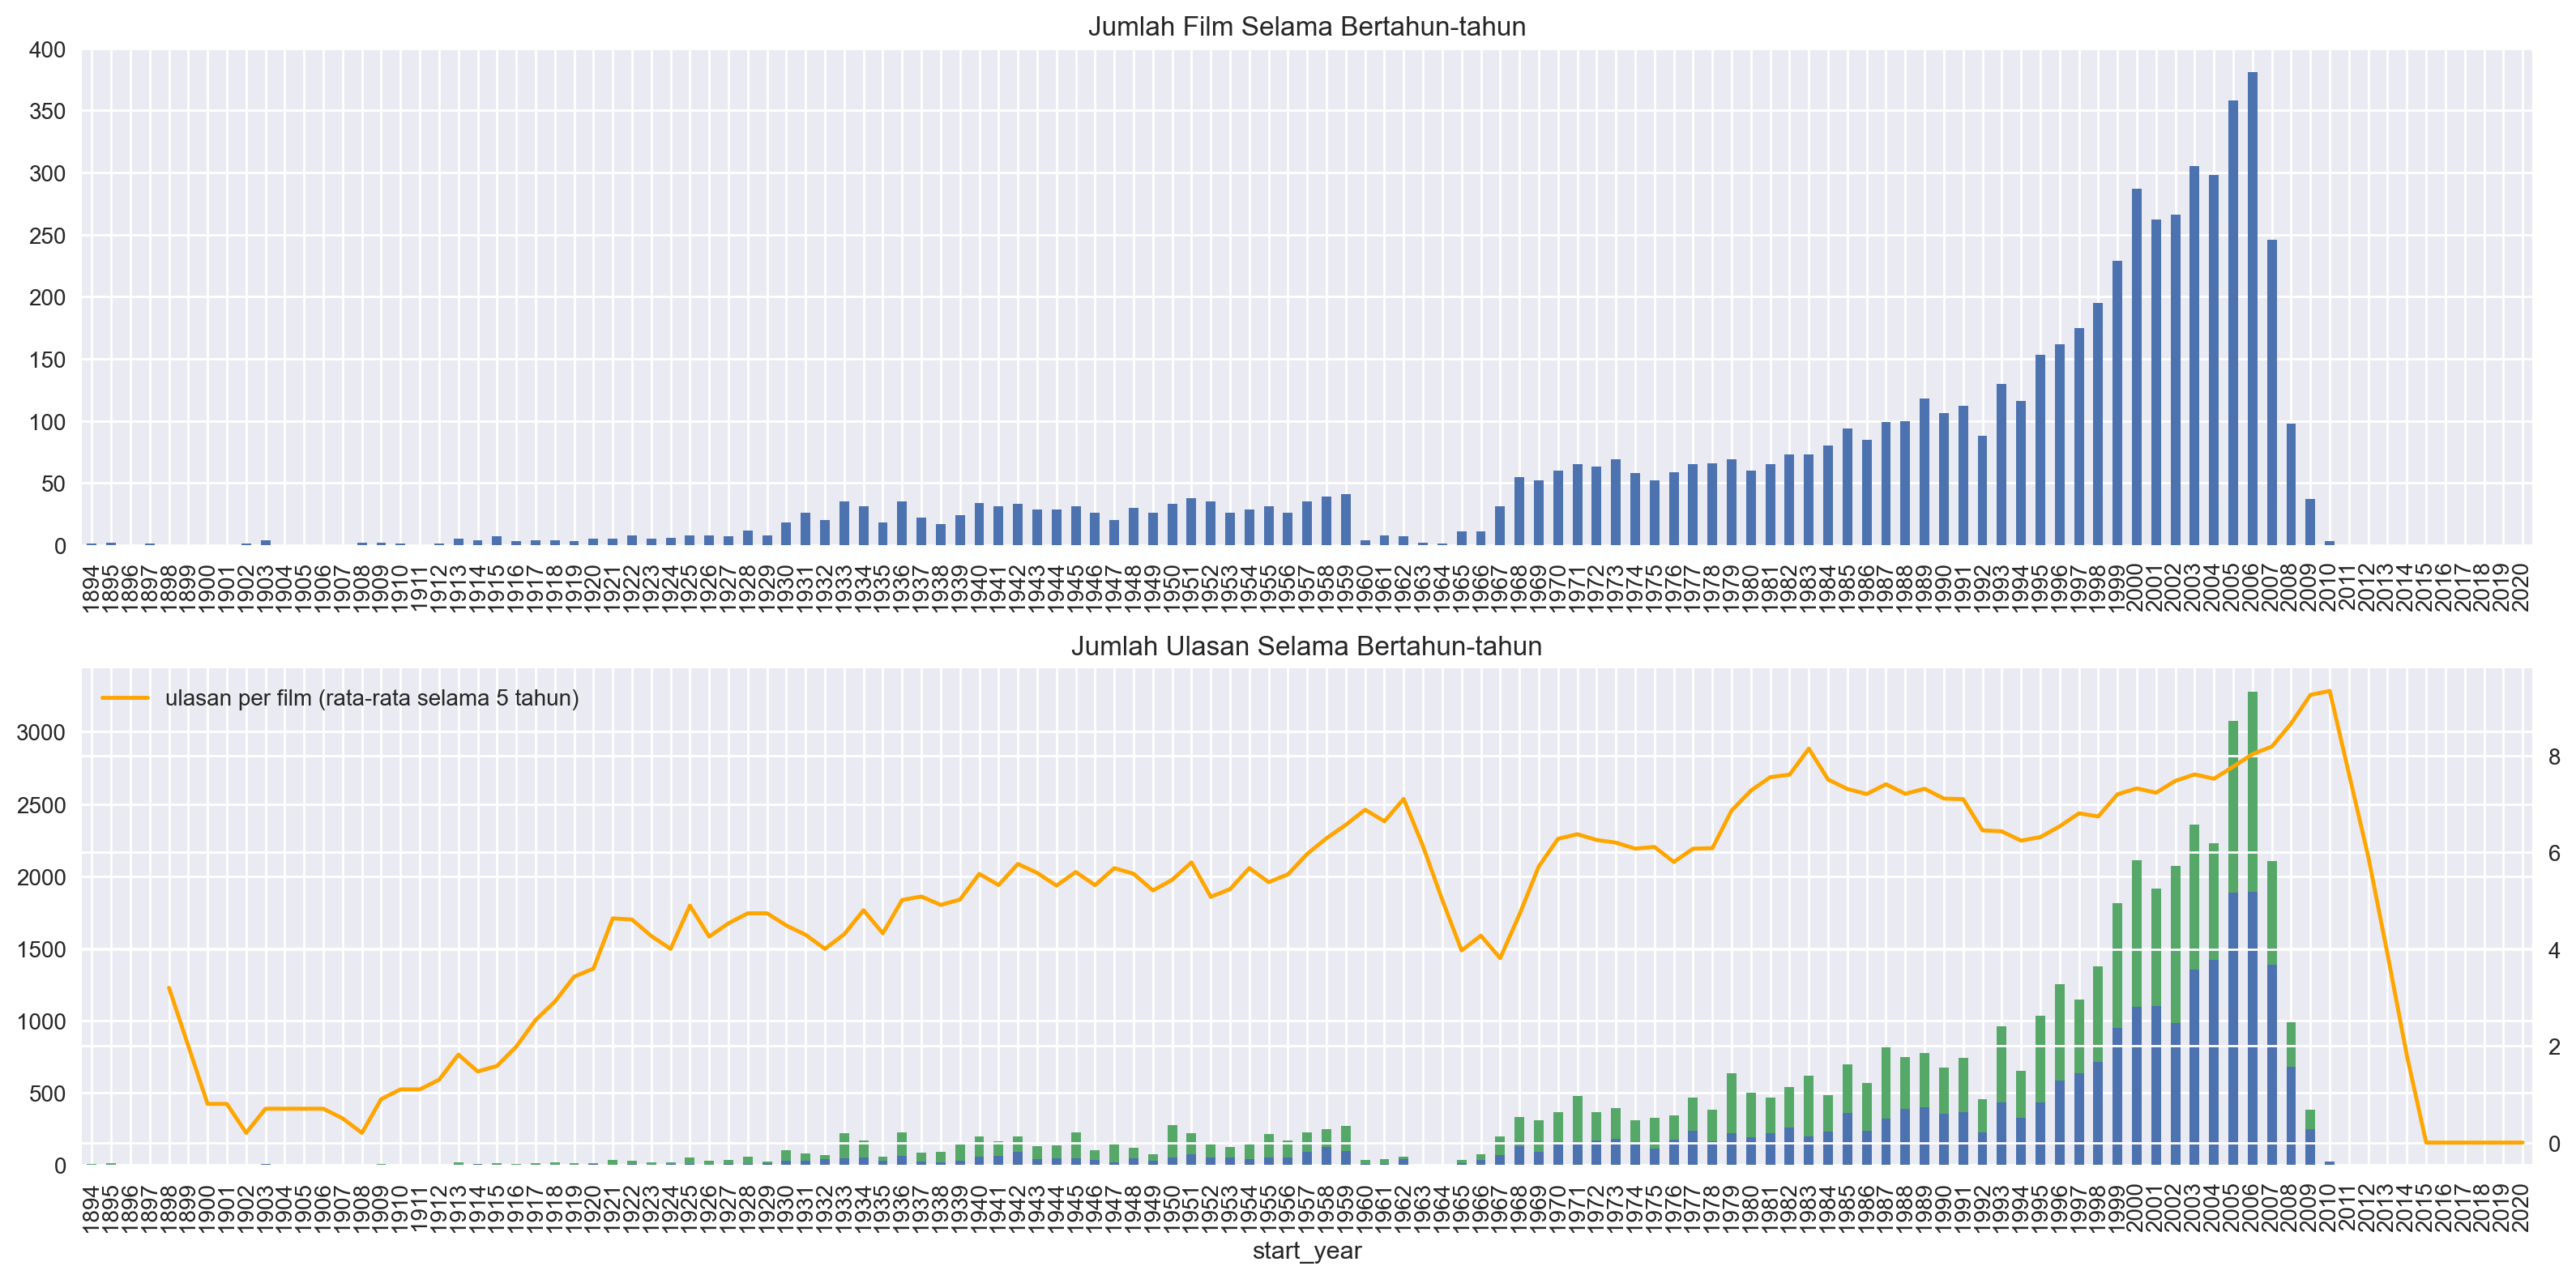

In [10]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8))

ax = axs[0]

dft1 = df_reviews[['tconst', 'start_year']].drop_duplicates() \
    ['start_year'].value_counts().sort_index()
dft1 = dft1.reindex(index=np.arange(dft1.index.min(), max(dft1.index.max(), 2021))).fillna(0)
dft1.plot(kind='bar', ax=ax)
ax.set_title('Jumlah Film Selama Bertahun-tahun')

ax = axs[1]

dft2 = df_reviews.groupby(['start_year', 'pos'])['pos'].count().unstack()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)

dft2.plot(kind='bar', stacked=True, label='#ulasan  (neg, pos)', ax=ax)

dft2 = df_reviews['start_year'].value_counts().sort_index()
dft2 = dft2.reindex(index=np.arange(dft2.index.min(), max(dft2.index.max(), 2021))).fillna(0)
dft3 = (dft2/dft1).fillna(0)
axt = ax.twinx()
dft3.reset_index(drop=True).rolling(5).mean().plot(color='orange', label='ulasan per film (rata-rata selama 5 tahun)', ax=axt)

lines, labels = axt.get_legend_handles_labels()
ax.legend(lines, labels, loc='upper left')

ax.set_title('Jumlah Ulasan Selama Bertahun-tahun') 

fig.tight_layout()

Dilihat dari grafik diatas, film film semakin banyak diproduksi semakin bergesernya waktu.


Periksa distribusi jumlah ulasan per film dengan penghitungan yang tepat dan KDE (hanya untuk mengetahui perbedaannya dari penghitungan yang tepat)

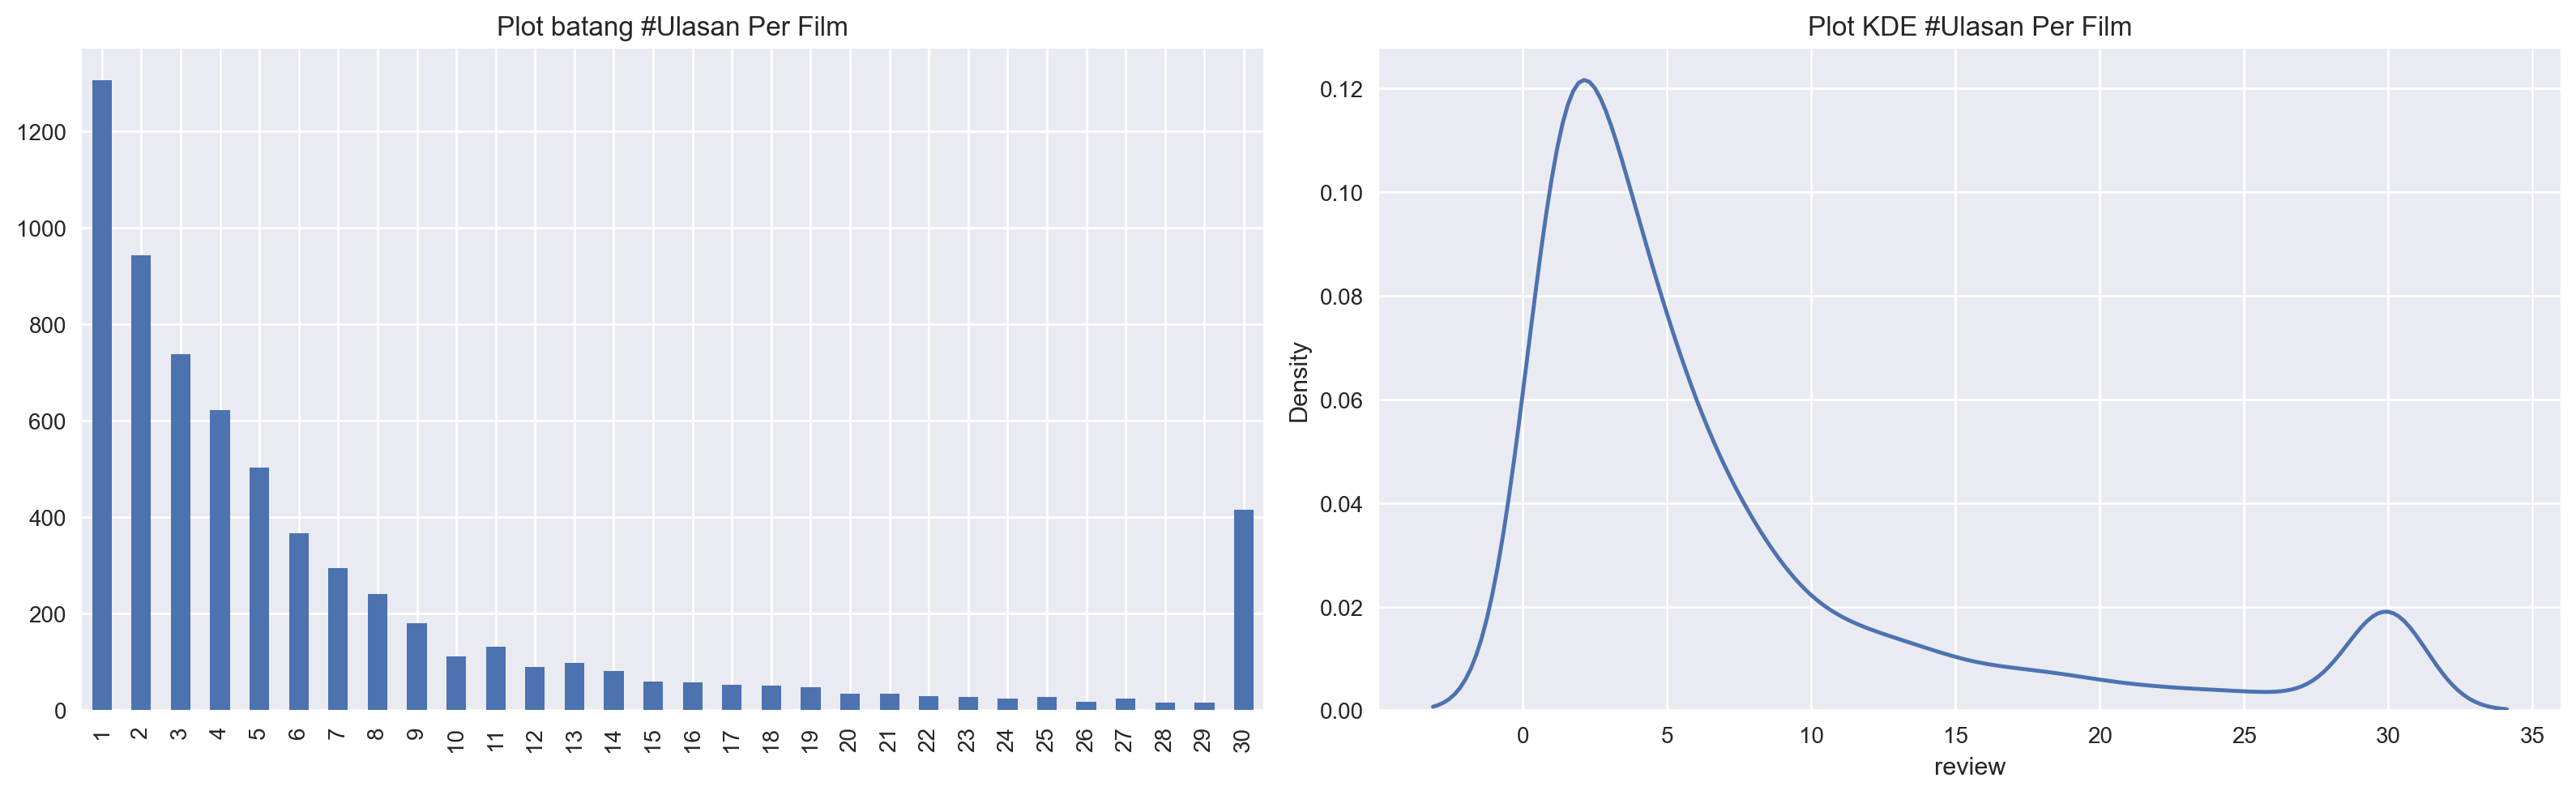

In [11]:
fig, axs = plt.subplots(1, 2, figsize=(16, 5))

ax = axs[0]
dft = df_reviews.groupby('tconst')['review'].count() \
    .value_counts() \
    .sort_index()
dft.plot.bar(ax=ax)
ax.set_title('Plot batang #Ulasan Per Film')

ax = axs[1]
dft = df_reviews.groupby('tconst')['review'].count()
sns.kdeplot(dft, ax=ax)
ax.set_title('Plot KDE #Ulasan Per Film') 

fig.tight_layout()

In [12]:
df_reviews['pos'].value_counts()

0    23715
1    23614
Name: pos, dtype: int64

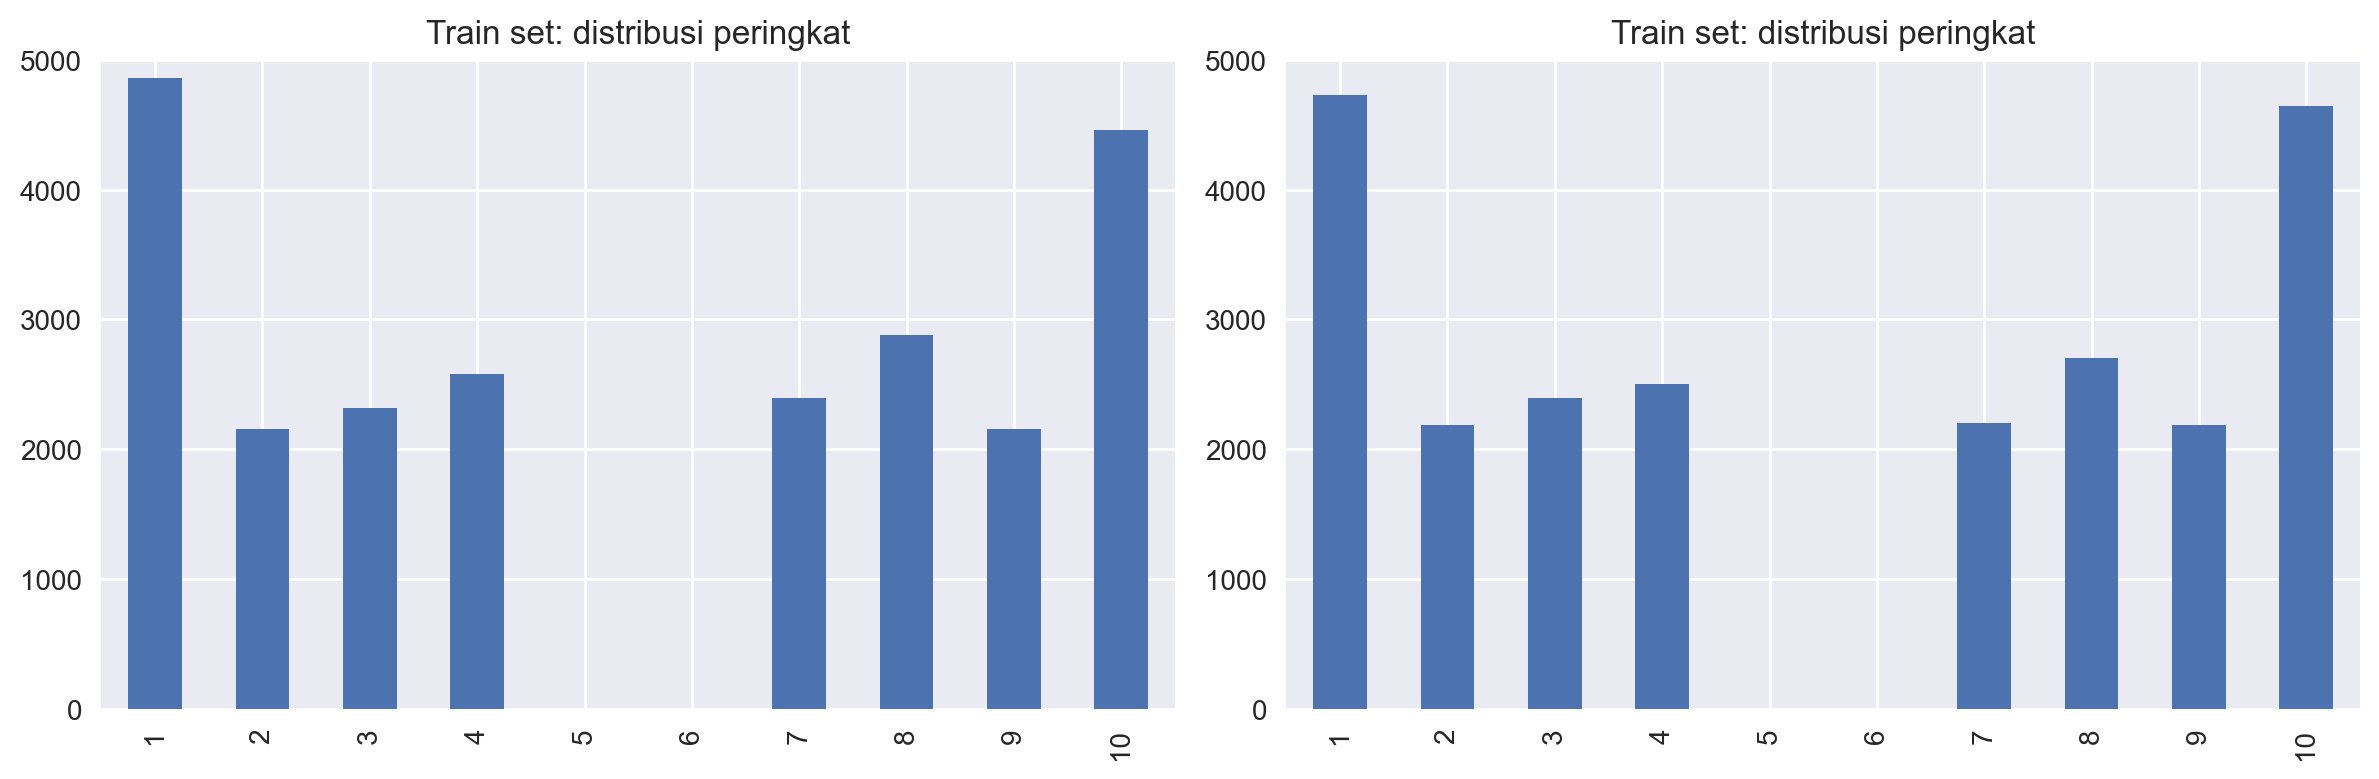

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 4))

ax = axs[0]
dft = df_reviews.query('ds_part == "train"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

ax = axs[1]
dft = df_reviews.query('ds_part == "test"')['rating'].value_counts().sort_index()
dft = dft.reindex(index=np.arange(min(dft.index.min(), 1), max(dft.index.max(), 11))).fillna(0)
dft.plot.bar(ax=ax)
ax.set_ylim([0, 5000])
ax.set_title('Train set: distribusi peringkat')

fig.tight_layout()

Distribusi ulasan negatif dan positif selama bertahun-tahun untuk dua bagian dataset

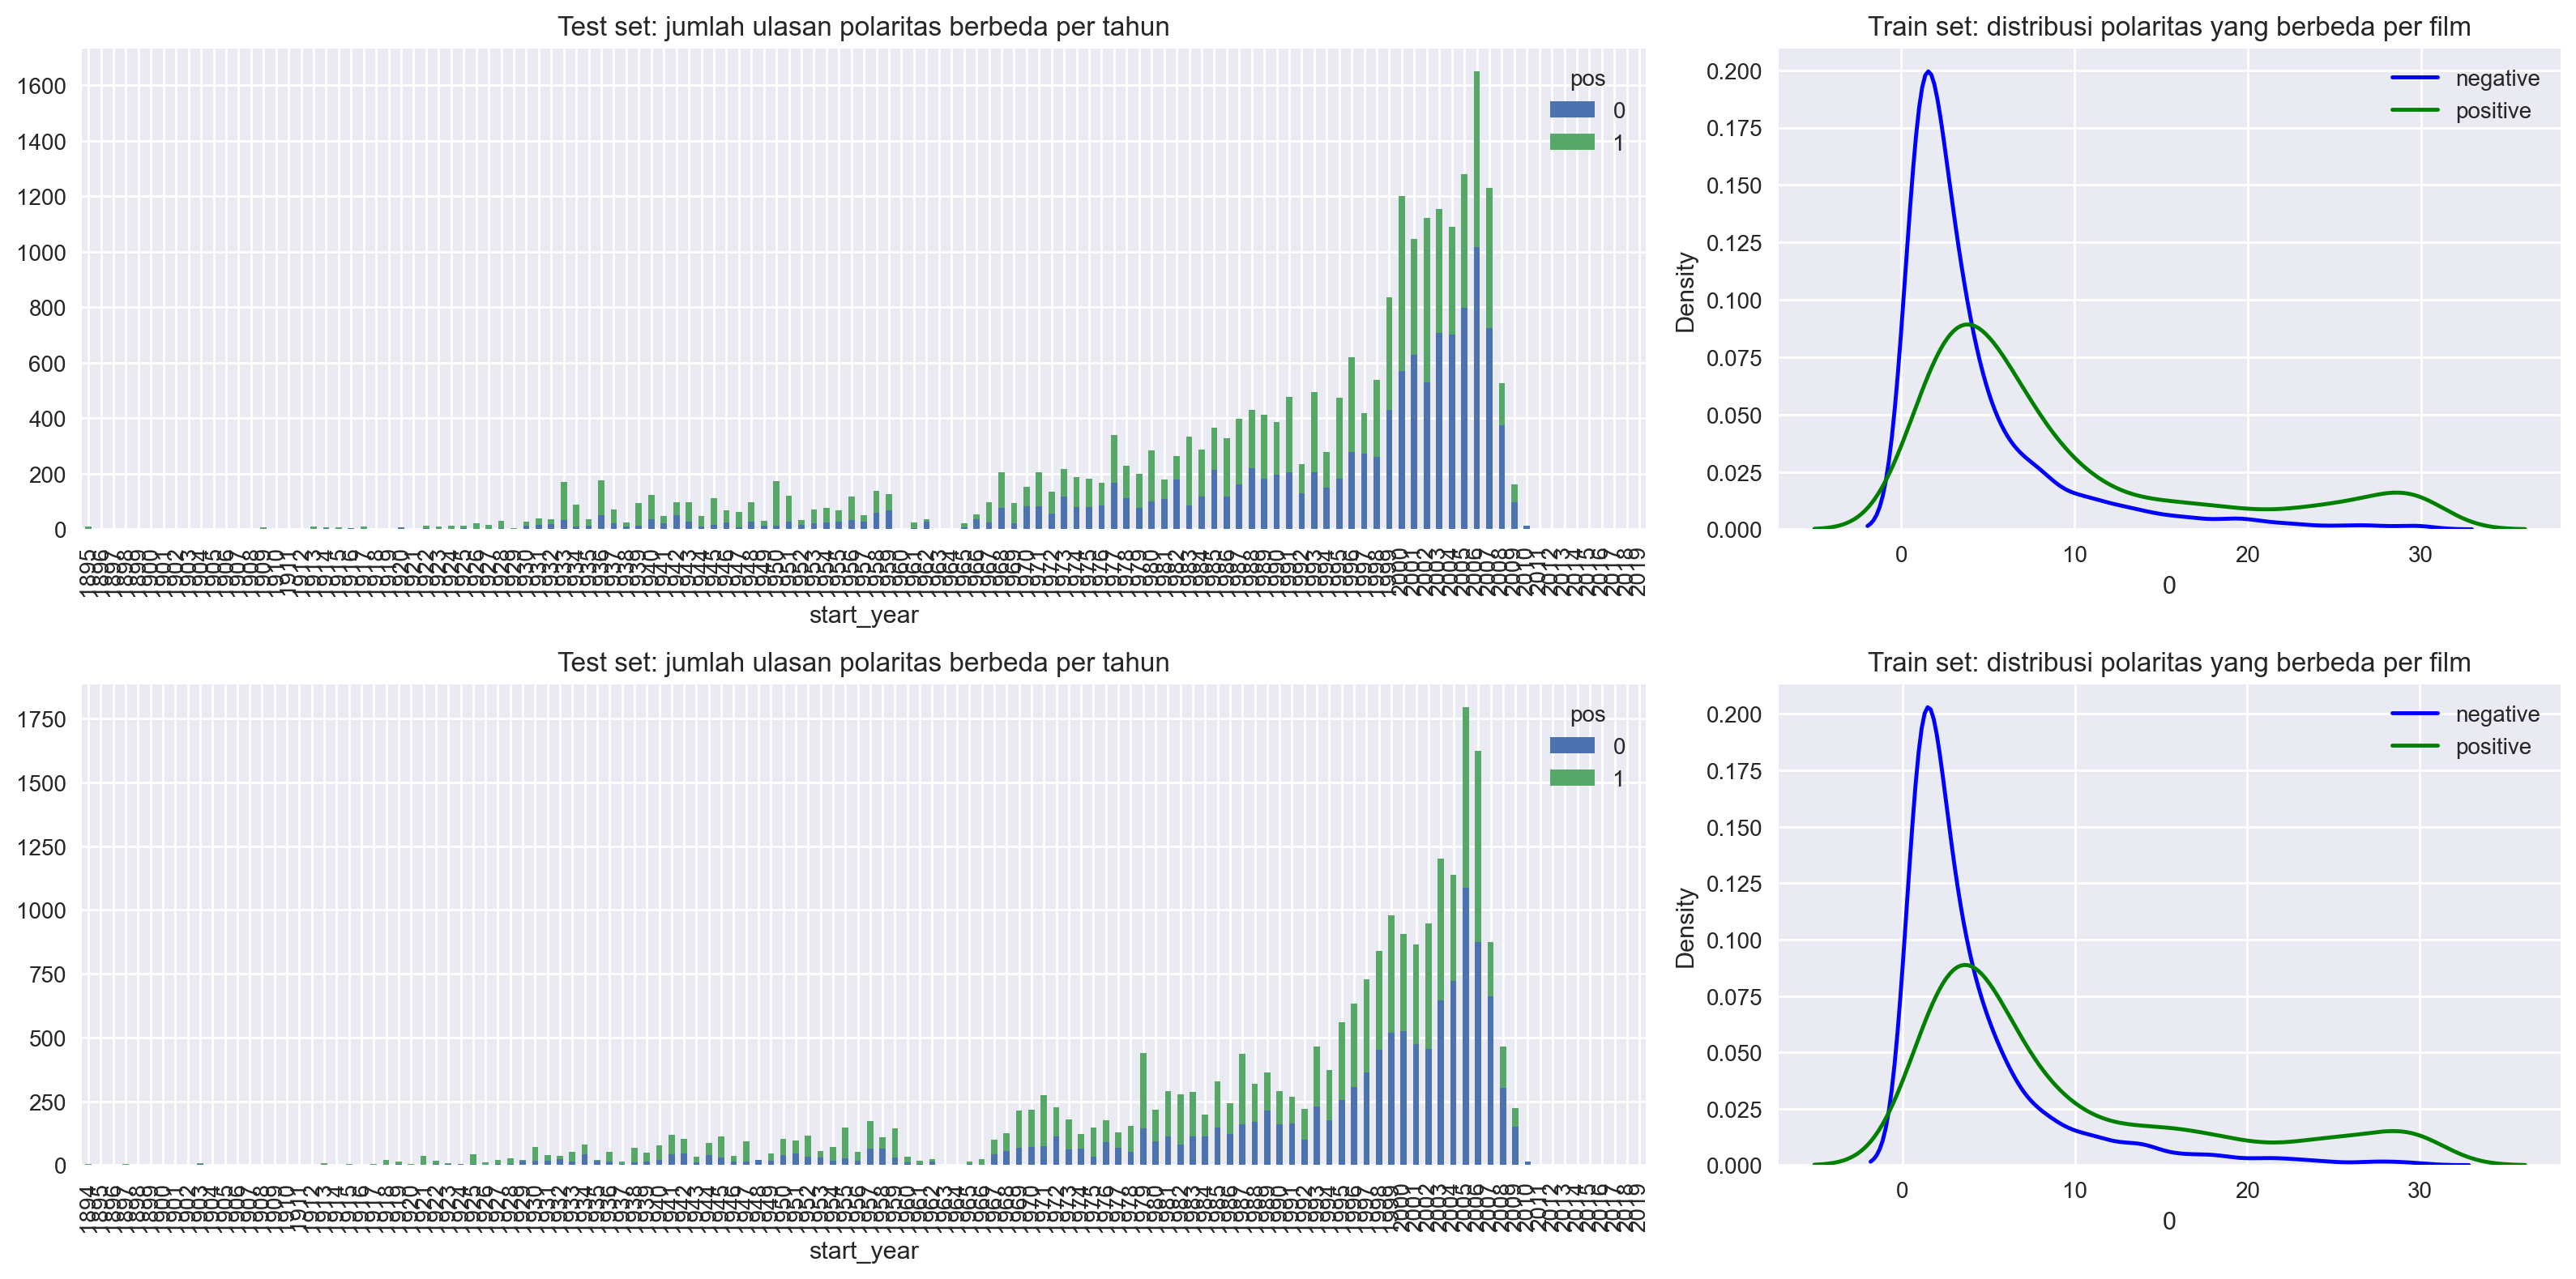

In [14]:
fig, axs = plt.subplots(2, 2, figsize=(16, 8), gridspec_kw=dict(width_ratios=(2, 1), height_ratios=(1, 1)))

ax = axs[0][0]

dft = df_reviews.query('ds_part == "train"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: jumlah ulasan polaritas berbeda per tahun')

ax = axs[0][1]

dft = df_reviews.query('ds_part == "train"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: distribusi polaritas yang berbeda per film')

ax = axs[1][0]

dft = df_reviews.query('ds_part == "test"').groupby(['start_year', 'pos'])['pos'].count().unstack()
dft.index = dft.index.astype('int')
dft = dft.reindex(index=np.arange(dft.index.min(), max(dft.index.max(), 2020))).fillna(0)
dft.plot(kind='bar', stacked=True, ax=ax)
ax.set_title('Test set: jumlah ulasan polaritas berbeda per tahun')

ax = axs[1][1]

dft = df_reviews.query('ds_part == "test"').groupby(['tconst', 'pos'])['pos'].count().unstack()
sns.kdeplot(dft[0], color='blue', label='negative', kernel='epa', ax=ax)
sns.kdeplot(dft[1], color='green', label='positive', kernel='epa', ax=ax)
ax.legend()
ax.set_title('Train set: distribusi polaritas yang berbeda per film')

fig.tight_layout()

## Prosedur Evaluasi

Menyusun evaluasi yang dapat digunakan untuk semua model dalam tugas ini secara rutin

In [15]:
import sklearn.metrics as metrics

def evaluate_model(model, train_features, train_target, test_features, test_target):
    
    eval_stats = {}
    
    fig, axs = plt.subplots(1, 3, figsize=(20, 6)) 
    
    for type, features, target in (('train', train_features, train_target), ('test', test_features, test_target)):
        
        eval_stats[type] = {}
    
        pred_target = model.predict(features)
        pred_proba = model.predict_proba(features)[:, 1]
        
        # F1
        f1_thresholds = np.arange(0, 1.01, 0.05)
        f1_scores = [metrics.f1_score(target, pred_proba>=threshold) for threshold in f1_thresholds]
        
        # ROC
        fpr, tpr, roc_thresholds = metrics.roc_curve(target, pred_proba)
        roc_auc = metrics.roc_auc_score(target, pred_proba)    
        eval_stats[type]['ROC AUC'] = roc_auc

        # PRC
        precision, recall, pr_thresholds = metrics.precision_recall_curve(target, pred_proba)
        aps = metrics.average_precision_score(target, pred_proba)
        eval_stats[type]['APS'] = aps
        
        if type == 'train':
            color = 'blue'
        else:
            color = 'green'

        # Scor F1 
        ax = axs[0]
        max_f1_score_idx = np.argmax(f1_scores)
        ax.plot(f1_thresholds, f1_scores, color=color, label=f'{type}, max={f1_scores[max_f1_score_idx]:.2f} @ {f1_thresholds[max_f1_score_idx]:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(f1_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(f1_thresholds[closest_value_idx], f1_scores[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('threshold')
        ax.set_ylabel('F1')
        ax.legend(loc='lower center')
        ax.set_title(f'Skor F1') 

        # ROC
        ax = axs[1]    
        ax.plot(fpr, tpr, color=color, label=f'{type}, ROC AUC={roc_auc:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(roc_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'            
            ax.plot(fpr[closest_value_idx], tpr[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.plot([0, 1], [0, 1], color='grey', linestyle='--')
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('FPR')
        ax.set_ylabel('TPR')
        ax.legend(loc='lower center')        
        ax.set_title(f'Kurva ROC')
        
        # PRC
        ax = axs[2]
        ax.plot(recall, precision, color=color, label=f'{type}, AP={aps:.2f}')
        # menetapkan persilangan untuk beberapa ambang batas
        for threshold in (0.2, 0.4, 0.5, 0.6, 0.8):
            closest_value_idx = np.argmin(np.abs(pr_thresholds-threshold))
            marker_color = 'orange' if threshold != 0.5 else 'red'
            ax.plot(recall[closest_value_idx], precision[closest_value_idx], color=marker_color, marker='X', markersize=7)
        ax.set_xlim([-0.02, 1.02])    
        ax.set_ylim([-0.02, 1.02])
        ax.set_xlabel('recall')
        ax.set_ylabel('precision')
        ax.legend(loc='lower center')
        ax.set_title(f'PRC')        

        eval_stats[type]['Akurasi'] = metrics.accuracy_score(target, pred_target)
        eval_stats[type]['F1'] = metrics.f1_score(target, pred_target)
    
    df_eval_stats = pd.DataFrame(eval_stats)
    df_eval_stats = df_eval_stats.round(2)
    df_eval_stats = df_eval_stats.reindex(index=('Akurasi', 'F1', 'APS', 'ROC AUC'))
    
    print(df_eval_stats)
    
    return

## Normalisasi

Kami menganggap semua model di bawah menerima teks dalam huruf kecil dan tanpa angka, tanda baca, dll.

In [16]:
#semua text akan dijadikan lowercase dan hanya menerima huruf latin saja.
df_reviews['review_norm'] = df_reviews['review'].str.lower().str.replace('[^A-zA-Z]', ' ')

## Pisahkan Train / Test

Untungnya, seluruh dataset sudah dibagi menjadi satu bagian untuk melatih/menguji. Bendera yang sesuai adalah 'ds_part'.

In [17]:
df_reviews_train = df_reviews.query('ds_part == "train"').copy()
df_reviews_test = df_reviews.query('ds_part == "test"').copy()

train_target = df_reviews_train['pos']
test_target = df_reviews_test['pos']

print(df_reviews_train.shape)
print(df_reviews_test.shape)

(23796, 18)
(23533, 18)


## Bekerja dengan Model

### Model 0 - Konstan

Model ini dibuat untuk dijadikan Baseline model sehingga telrihat apakah model lain "bekerja dengan semestinya" atau tidak.

In [18]:
from sklearn.dummy import DummyClassifier

In [19]:
model_dummy = DummyClassifier(strategy='constant', constant=1)

In [20]:
model_dummy = model_dummy.fit(df_reviews_train, train_target)

         train  test
Akurasi   0.50  0.50
F1        0.67  0.67
APS       0.50  0.50
ROC AUC   0.50  0.50


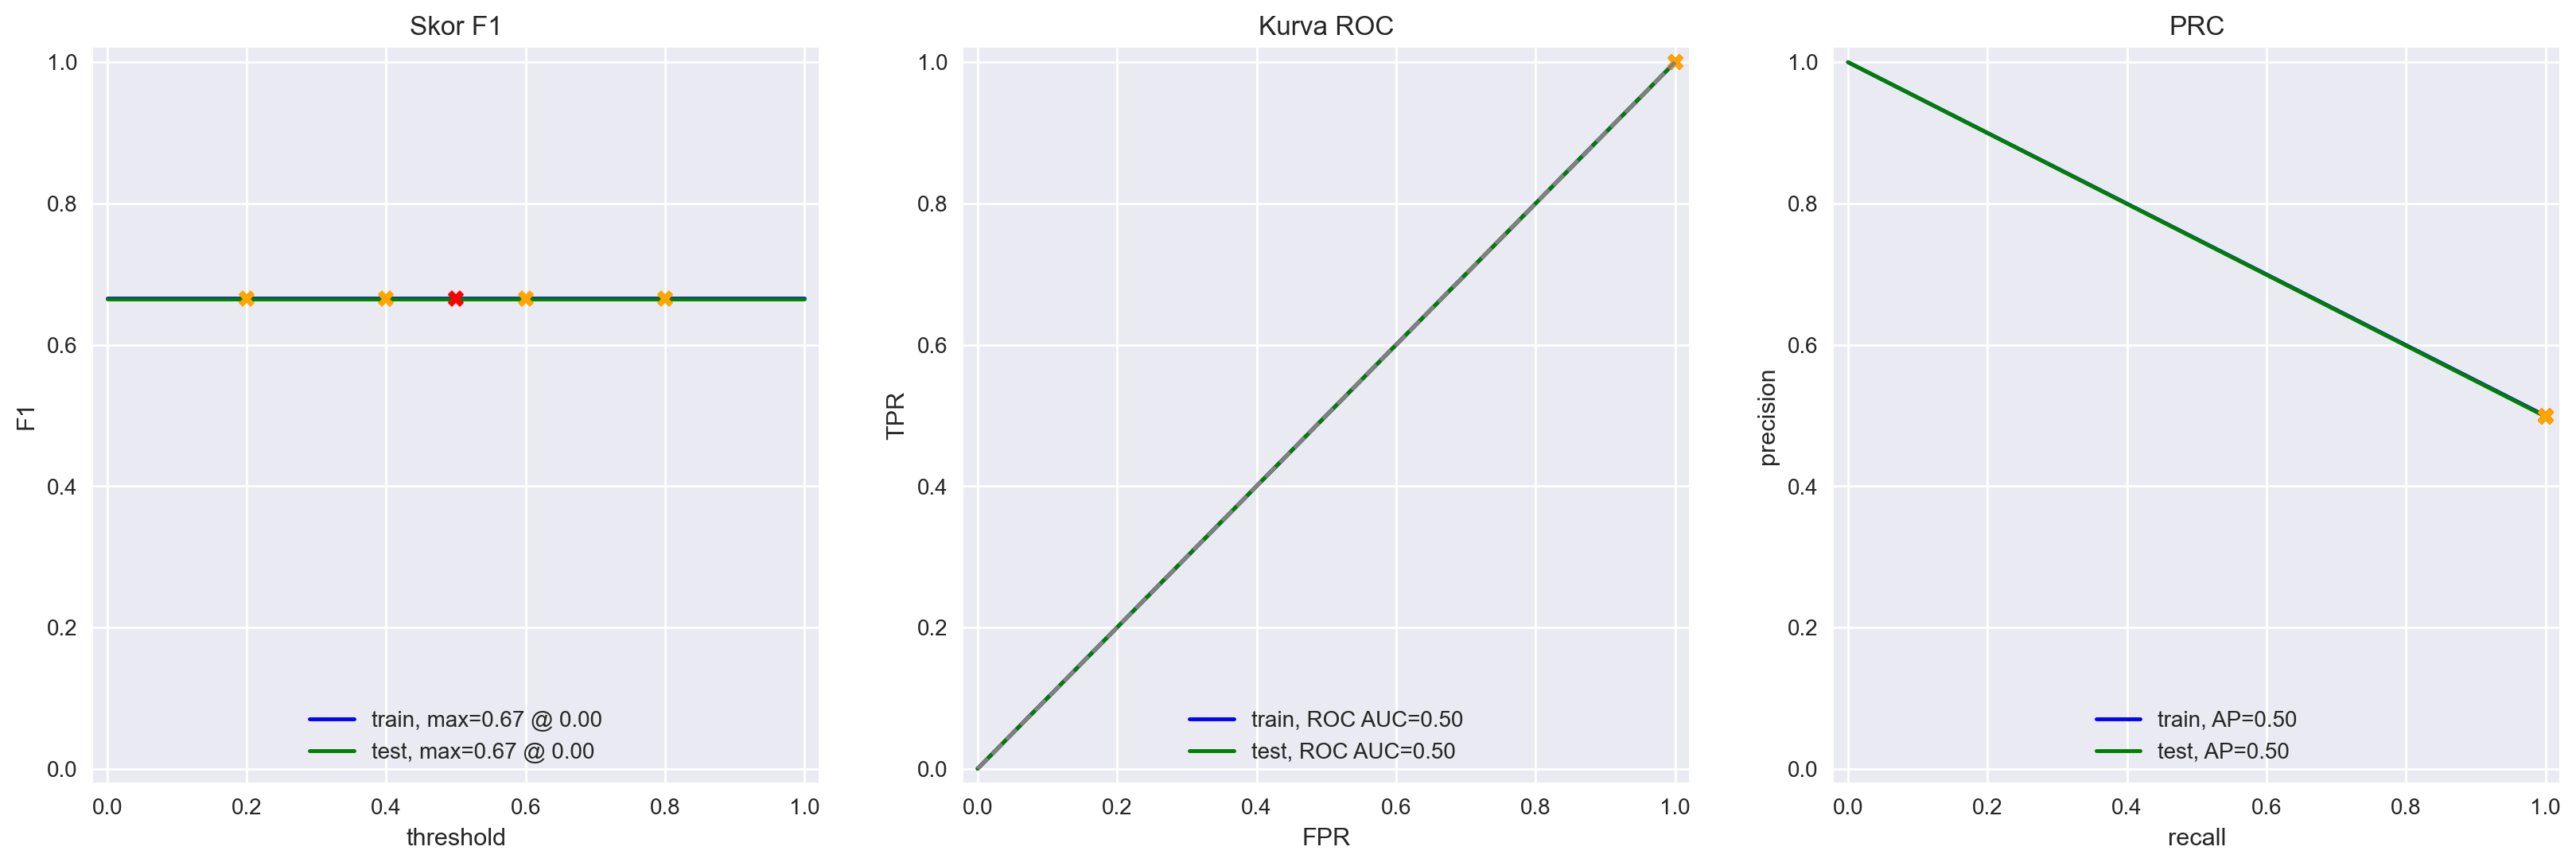

In [21]:
evaluate_model(model_dummy, df_reviews_train, train_target, df_reviews_test, test_target)

### Model 1 - NLTK, TF-IDF dan LR

In [22]:
import nltk

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression

from nltk.corpus import stopwords

In [23]:
#nltk.download('stopwords')
#download stopwords jika belum ada

In [24]:
tfidf_vectorizer = TfidfVectorizer(stop_words=stopwords.words('english'))

In [25]:
train_features_1 = tfidf_vectorizer.fit_transform(df_reviews_train['review_norm'])
print(train_features_1.shape)

(23796, 71676)


In [26]:
test_features_1 = tfidf_vectorizer.transform(df_reviews_test['review_norm'])
print(test_features_1.shape)

(23533, 71676)


In [27]:
from sklearn.linear_model import LogisticRegression

model_1 = LogisticRegression()

model_1.fit(train_features_1, train_target)

LogisticRegression()

         train  test
Akurasi   0.94  0.88
F1        0.94  0.88
APS       0.98  0.95
ROC AUC   0.98  0.95


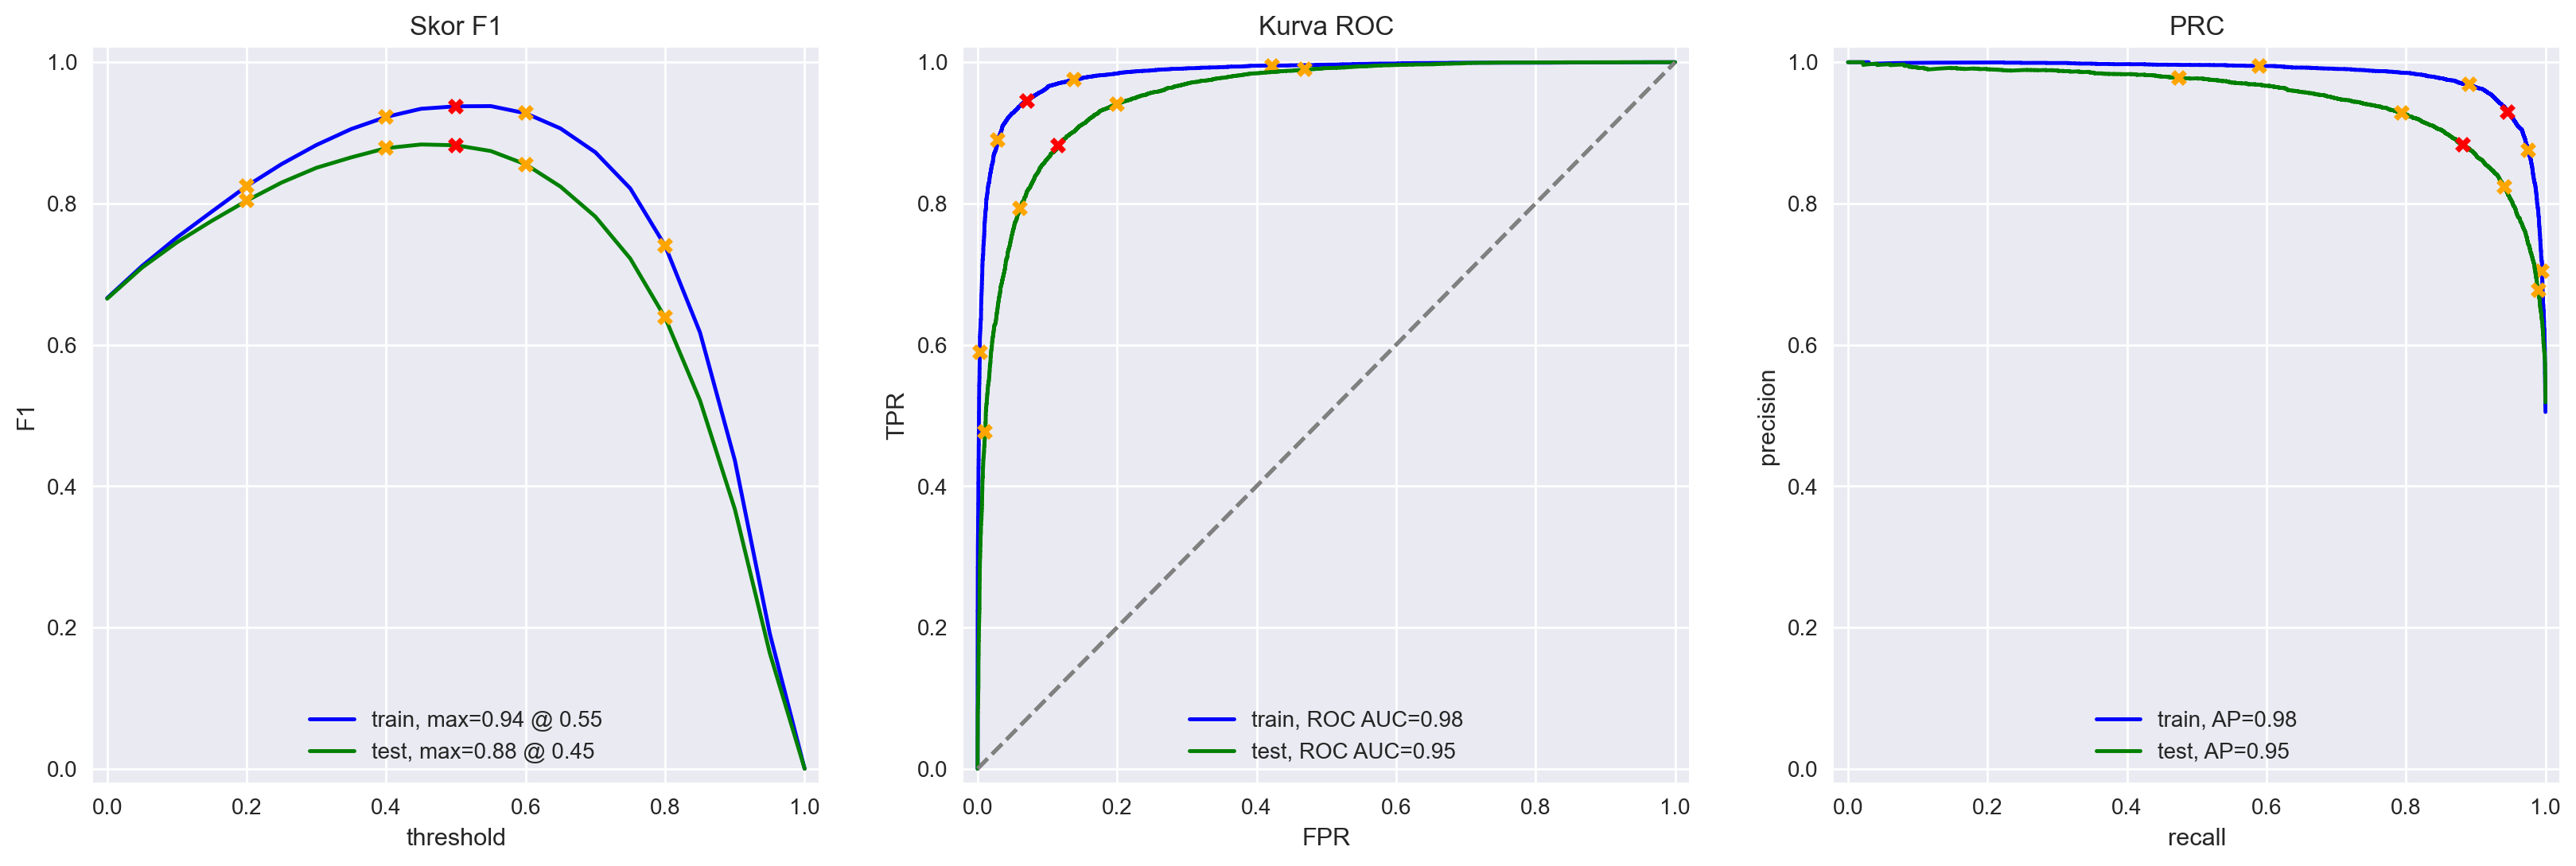

In [28]:
evaluate_model(model_1, train_features_1, train_target, test_features_1, test_target)

### Model 3 - spaCy, TF-IDF dan LR

In [29]:
#spacy.cli.download("en_core_web_sm")

In [30]:
nlp = spacy.load("en_core_web_sm", disable=['parser', 'ner'])

In [31]:
def text_preprocessing_3(text):
    
    doc = nlp(text)
    #tokens = [token.lemma_ for token in doc if not token.is_stop]
    tokens = [token.lemma_ for token in doc]
    
    return ' '.join(tokens)

In [32]:
df_reviews_train['review_tokenized'] = df_reviews_train['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23796 [00:00<?, ?it/s]

In [33]:
df_reviews_test['review_tokenized'] = df_reviews_test['review_norm'].progress_apply(lambda x: text_preprocessing_3(x))

  0%|          | 0/23533 [00:00<?, ?it/s]

In [34]:
df_reviews_test['review_tokenized']

2        there be no real story the film seem more like...
3        um       a serious film about troubled teen in...
4        I m totally agree with garryjohal from singapo...
5        this be the first movie I ve see from singapor...
6        yes non singaporean s can t see what s the big...
                               ...                        
47326    this be another of my favorite columbo   it sp...
47327    talk about be bore   I get this expect a fasci...
47328    I never think I d say this about a biopic   bu...
47329    spirit and chaos be an artistic biopic of miya...
47330    I ll make this brief   this be a joy to watch ...
Name: review_tokenized, Length: 23533, dtype: object

In [35]:
df_reviews_train['review_tokenized'].sample(5)

22177    the three stooge have always be some of the ma...
20690    this film be terrible   you don t really need ...
46671    believe it or not    the woodchipper massacre ...
5929     as a producer of indie movie and a harsh criti...
42596    boy what a dud this mess be but it only last a...
Name: review_tokenized, dtype: object

In [36]:
df_reviews_test['review_tokenized'].sample(5)

36106    because of the depth of his character study an...
44004    this be a bizarre oddity   direct by the guy w...
30583    I m a fan of b grade    s film in which the he...
9785     I just watch descent   gawd what an awful movi...
37899    cowardly and cynical   ` the hospital   repres...
Name: review_tokenized, dtype: object

In [37]:
tfidf_vectorizer_3 = TfidfVectorizer()

In [38]:
train_features_3 = tfidf_vectorizer_3.fit_transform(df_reviews_train['review_tokenized'])
print(train_features_3.shape)

(23796, 59183)


In [39]:
test_features_3 = tfidf_vectorizer_3.transform(df_reviews_test['review_tokenized'])
print(test_features_3.shape)

(23533, 59183)


In [40]:
from sklearn.linear_model import LogisticRegression

model_3 = LogisticRegression()

model_3.fit(train_features_3, train_target)

LogisticRegression()

         train  test
Akurasi   0.93  0.88
F1        0.93  0.88
APS       0.98  0.95
ROC AUC   0.98  0.95


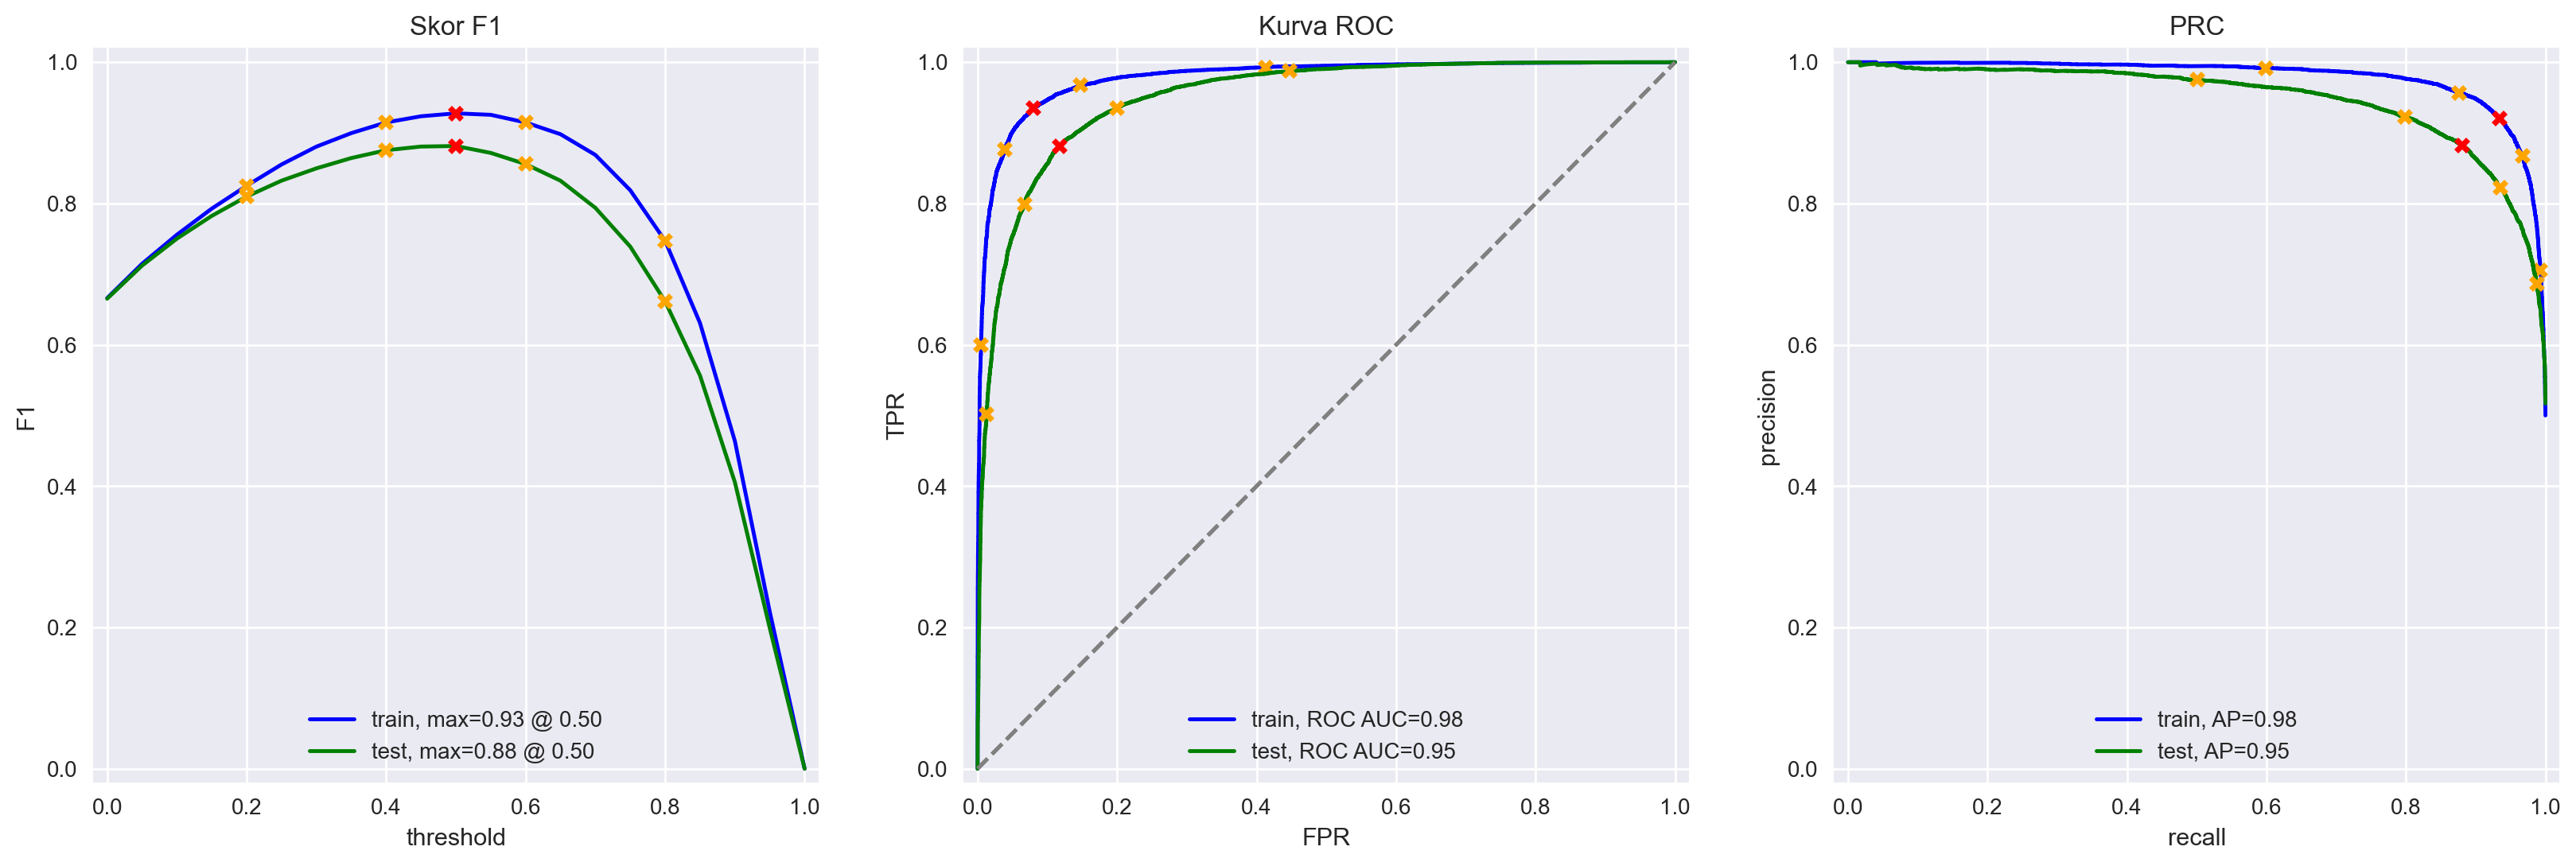

In [41]:
evaluate_model(model_3, train_features_3, train_target, test_features_3, test_target)

Model spacy dengan logistic regression memiliki nilai akurasi pada dataset train yang lebih kecil, hal ini bisa dibilang lebih baik dibandingkan dengan nltk, karena semakin jauh rentang akurasi dataset train dengan dataset test menandakan adanya overfitting. Ya mungkin tidak terlalu terlihat dari kedua model yang sudah dicoba.

### Model 4 - spaCy, TF-IDF dan LGBMClassifier

In [42]:
from lightgbm import LGBMClassifier

In [43]:
model_4 = LGBMClassifier(learning_rate=0.03, n_estimators=500)

         train  test
Akurasi   0.95  0.87
F1        0.95  0.87
APS       0.99  0.94
ROC AUC   0.99  0.94


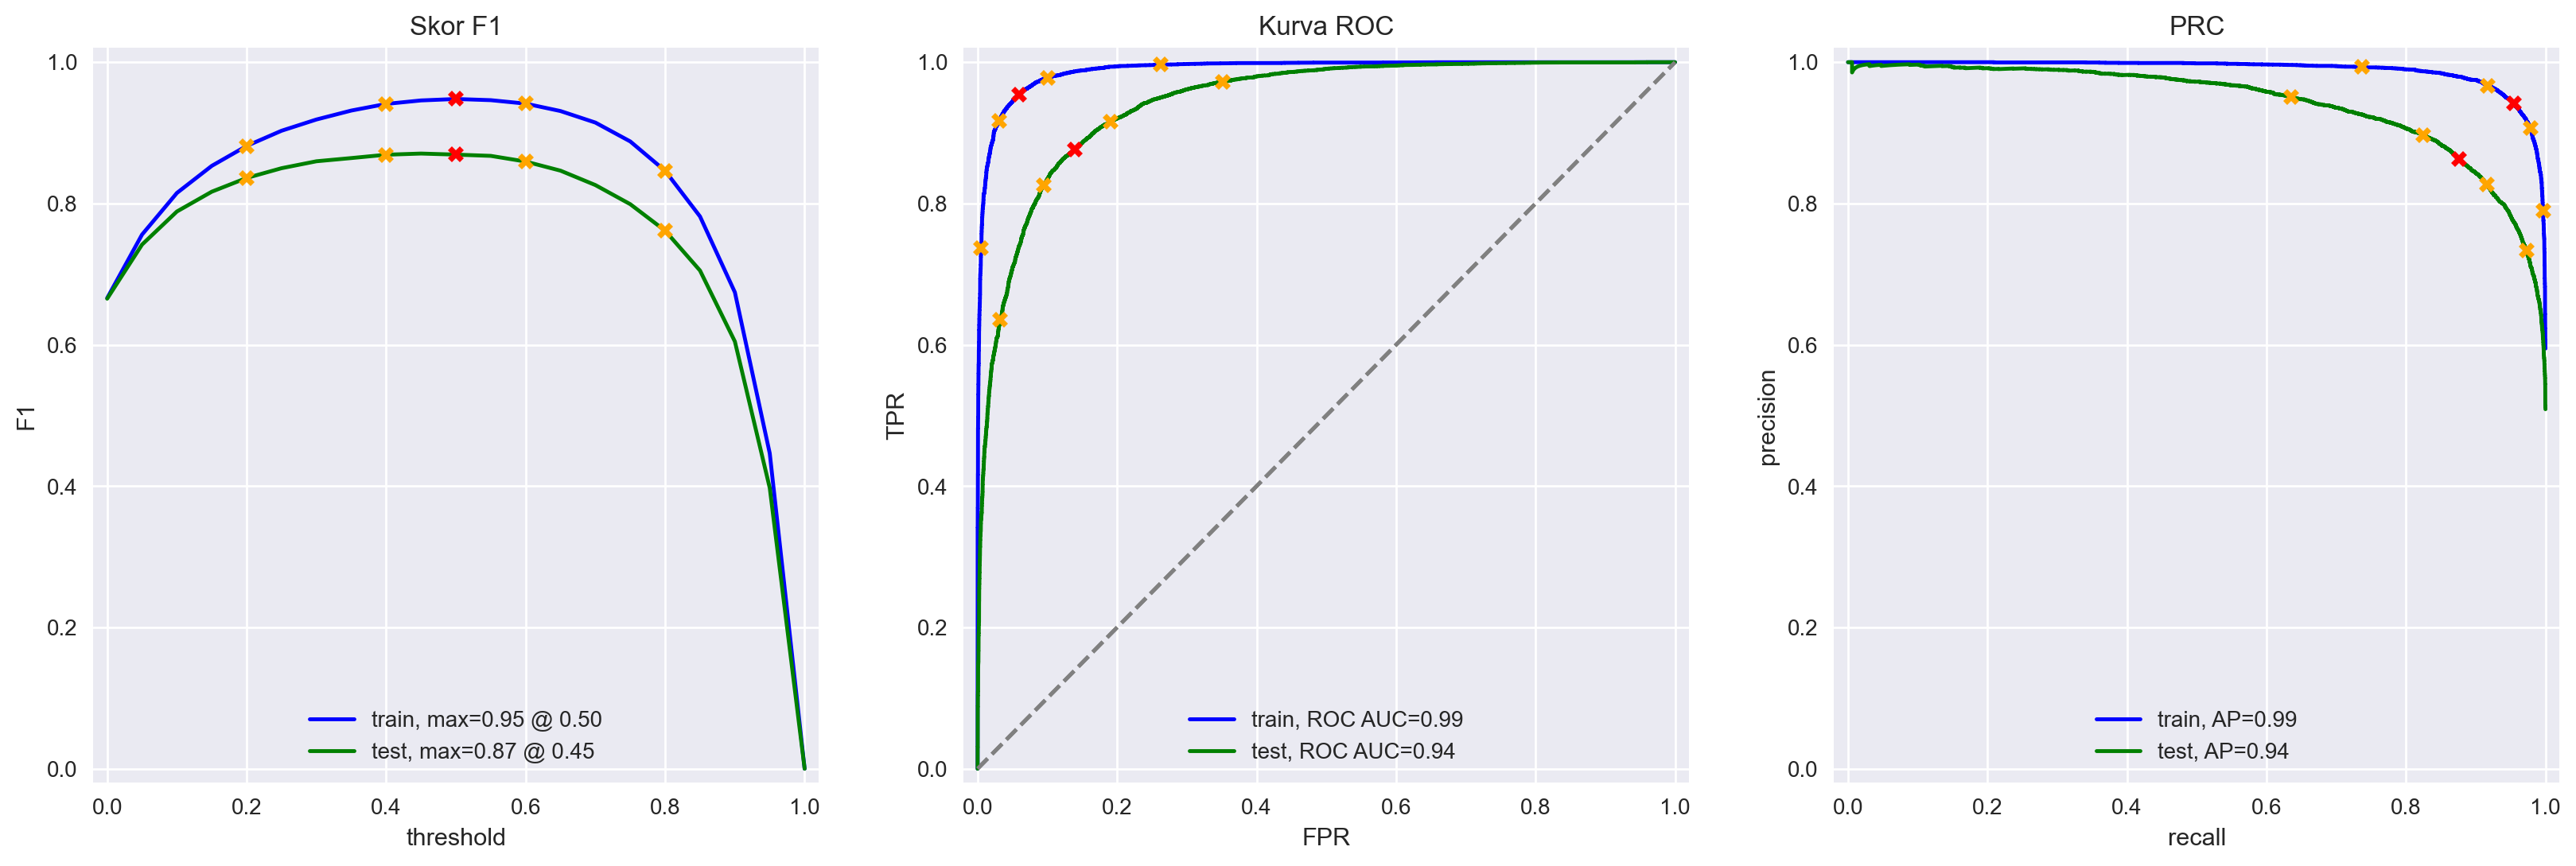

In [44]:
model_4.fit(train_features_3, train_target)
evaluate_model(model_4, train_features_3, train_target, test_features_3, test_target)

###  Model 9 - BERT

In [45]:
tokenizer = transformers.BertTokenizer.from_pretrained('bert-base-uncased')
config = transformers.BertConfig.from_pretrained('bert-base-uncased')
model = transformers.BertModel.from_pretrained('bert-base-uncased')

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [46]:
def BERT_text_to_embeddings(texts, max_length=512, batch_size=100, force_device=None, disable_progress_bar=False):
    
    ids_list = []
    attention_mask_list = []

    
    for input_text in tqdm(texts, disable=disable_progress_bar):
        ids = tokenizer.encode(input_text.lower(), add_special_tokens=True, truncation=True, max_length=max_length)
        padded = np.array(ids + [0]*(max_length - len(ids)))
        attention_mask = np.where(padded != 0, 1, 0)
        ids_list.append(padded)
        attention_mask_list.append(attention_mask)
    
    if force_device is not None:
        device = torch.device(force_device)
    else:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        
    model.to(device)
    if not disable_progress_bar:
        print(f'Menggunakan {device}.')
    

    embeddings = []

    for i in tqdm(range(math.ceil(len(ids_list)/batch_size)), disable=disable_progress_bar):
            
        ids_batch = torch.LongTensor(ids_list[batch_size*i:batch_size*(i+1)]).to(device)
        attention_mask_batch = torch.LongTensor(attention_mask_list[batch_size*i:batch_size*(i+1)]).to(device)
            
        with torch.no_grad():            
            model.eval()
            batch_embeddings = model(input_ids=ids_batch, attention_mask=attention_mask_batch)   
        embeddings.append(batch_embeddings[0][:,0,:].detach().cpu().numpy())
        
    return np.concatenate(embeddings)

In [47]:
# Perhatian! Menjalankan BERT untuk ribuan teks mungkin memakan waktu lama di CPU, setidaknya beberapa jam
#train_features_9 = BERT_text_to_embeddings(df_reviews_train['review_norm'], force_device='cuda')

In [48]:
data = np.load("D:\\Other\\features_9.npz")

In [49]:
train_features_9 = data['train_features_9']
test_features_9 = data['test_features_9']

In [50]:
print(df_reviews_train['review_norm'].shape)
print(train_features_9.shape)
print(train_target.shape)

(23796,)
(23796, 768)
(23796,)


In [52]:
print(df_reviews_test['review_norm'].shape)
print(test_features_9.shape)
print(test_target.shape)

(23533,)
(23533, 768)
(23533,)


In [53]:
from sklearn.linear_model import LogisticRegression

model_9 = LogisticRegression()

model_9.fit(train_features_9, train_target)

LogisticRegression()

         train  test
Akurasi   0.87  0.86
F1        0.87  0.86
APS       0.94  0.94
ROC AUC   0.94  0.94


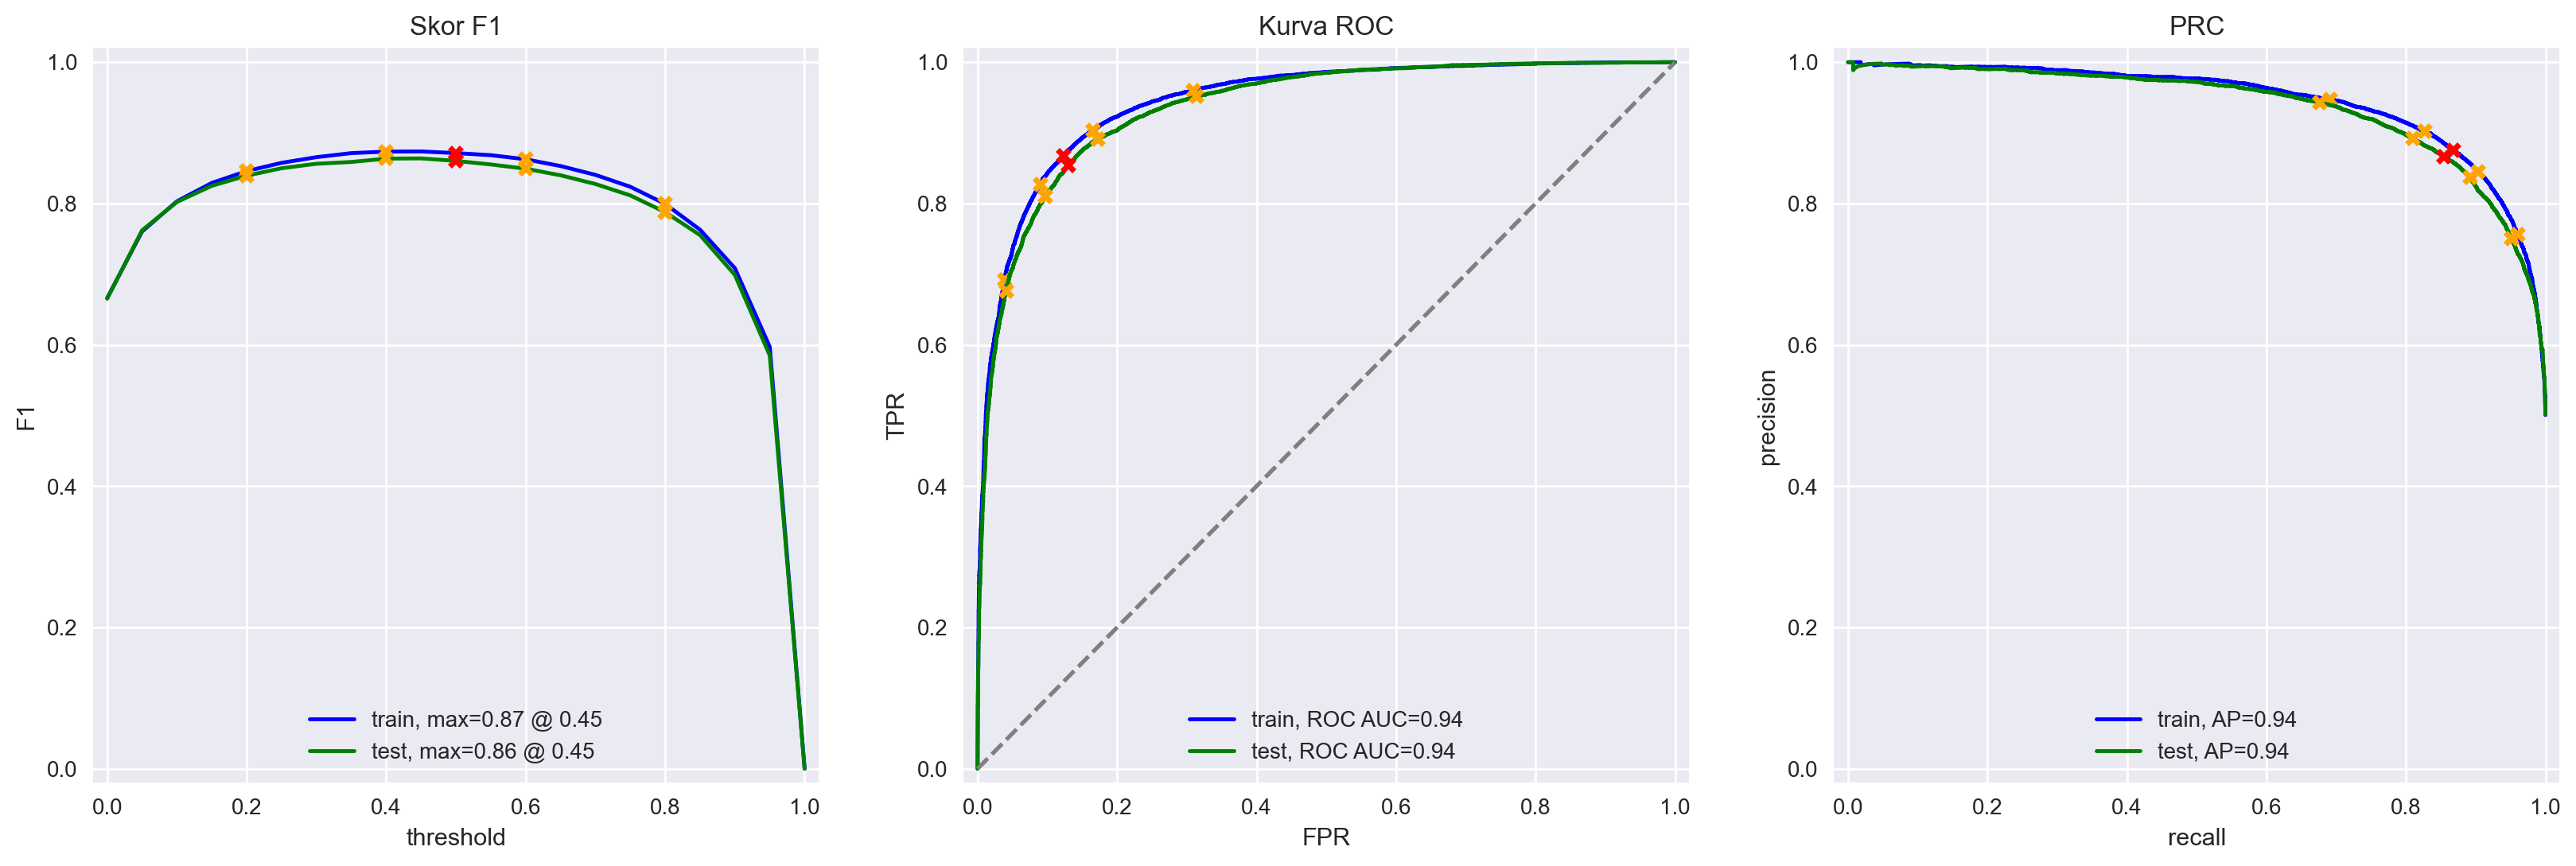

In [54]:
evaluate_model(model_9, train_features_9, train_target, test_features_9, test_target)

### Model 10 - BERT dengan LGBM

In [55]:
model_10 = LGBMClassifier(learning_rate=0.03, n_estimators=500)

         train  test
Akurasi   0.96  0.84
F1        0.96  0.84
APS       0.99  0.92
ROC AUC   0.99  0.92


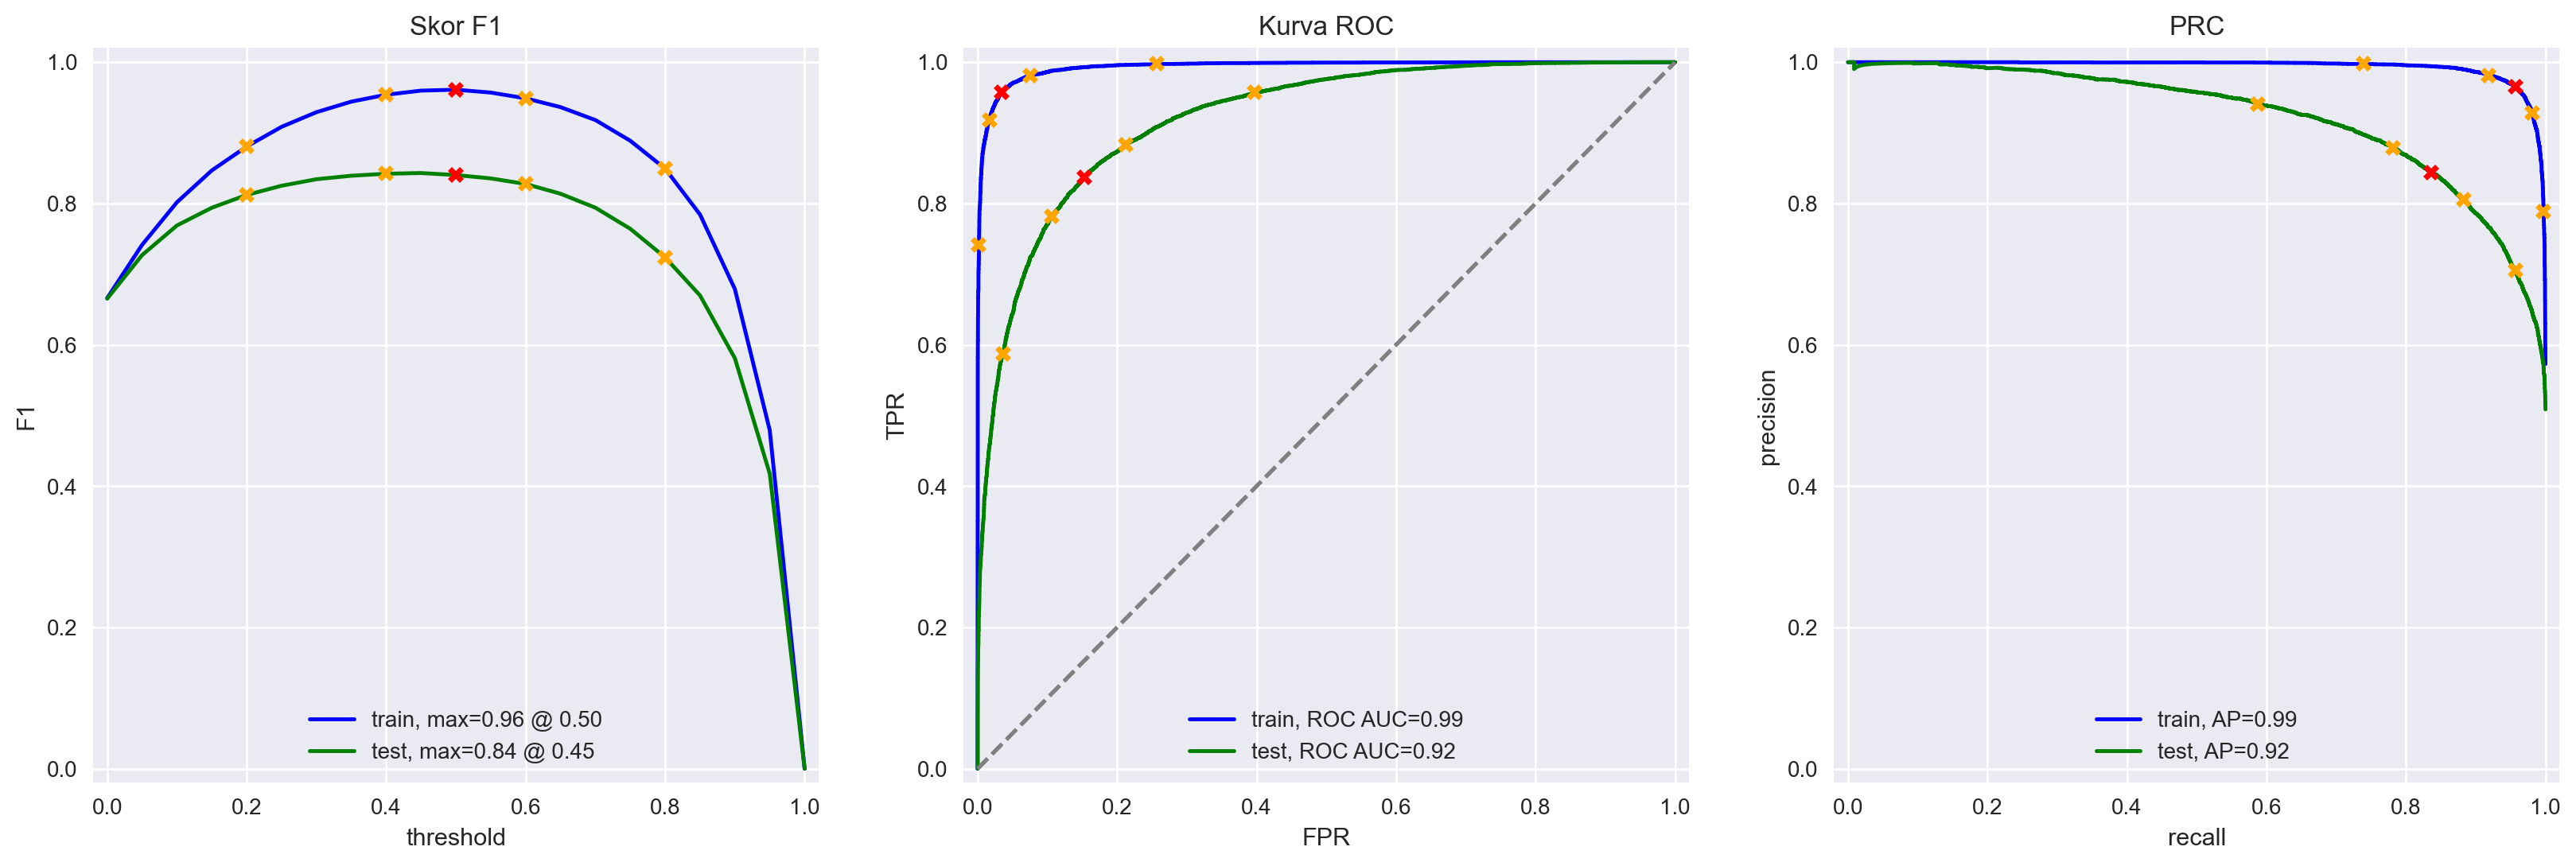

In [56]:
model_10.fit(train_features_9, train_target)
evaluate_model(model_10, train_features_9, train_target, test_features_9, test_target)

## Ulasan

In [57]:
# jangan ragu untuk menghapus ulasan ini dan mencoba model sendiri, di bawah ini hanyalah contoh 

my_reviews = pd.DataFrame([
    'I dont really like it, this type of film is not really my type', 
    'Boring, sleep in the middle of the movie.', 
    'This is hella good, i really like it',     
    'Even the actor looks really old and not interested in acting, are they gettnig paid to act this movie? Bad quality.', 
    'Didnt really expect the film will be this good! The author really pay attention to the detail', 
    'This film have two sides, bad things and good things, i think it is watchable. Maybe i watch it another time.', 
    'The jokes is really bad. There is not even one jokes that funny, everyone acted annoying, even children wouldnt like it!' 
], columns=['review'])

my_reviews['review_norm'] = my_reviews['review_norm'] = my_reviews['review'].str.lower().str.replace('[^a-zA-Z]', ' ')# <masukkan logika normalisasi yang sama di sini sebagaimana pada *dataset* utama>

my_reviews

,review,review_norm
0,"I dont really like it, this type of film is no...",i dont really like it this type of film is no...
1,"Boring, sleep in the middle of the movie.",boring sleep in the middle of the movie
2,"This is hella good, i really like it",this is hella good i really like it
3,Even the actor looks really old and not intere...,even the actor looks really old and not intere...
4,Didnt really expect the film will be this good...,didnt really expect the film will be this good...
5,"This film have two sides, bad things and good ...",this film have two sides bad things and good ...
6,The jokes is really bad. There is not even one...,the jokes is really bad there is not even one...


### Model 2

In [58]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_1.predict_proba(tfidf_vectorizer.transform(texts))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.48:  i dont really like it  this type of film is not really my type
0.02:  boring  sleep in the middle of the movie 
0.57:  this is hella good  i really like it
0.01:  even the actor looks really old and not interested in acting  are they gettnig paid to act this movi
0.49:  didnt really expect the film will be this good  the author really pay attention to the detail
0.31:  this film have two sides  bad things and good things  i think it is watchable  maybe i watch it anot
0.03:  the jokes is really bad  there is not even one jokes that funny  everyone acted annoying  even child


### Model 3

In [59]:
texts = my_reviews['review_norm']

my_reviews_pred_prob = model_3.predict_proba(tfidf_vectorizer_3.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.47:  i dont really like it  this type of film is not really my type
0.09:  boring  sleep in the middle of the movie 
0.71:  this is hella good  i really like it
0.00:  even the actor looks really old and not interested in acting  are they gettnig paid to act this movi
0.59:  didnt really expect the film will be this good  the author really pay attention to the detail
0.21:  this film have two sides  bad things and good things  i think it is watchable  maybe i watch it anot
0.00:  the jokes is really bad  there is not even one jokes that funny  everyone acted annoying  even child


### Model 4

In [60]:
texts = my_reviews['review_norm']

tfidf_vectorizer_4 = tfidf_vectorizer_3
my_reviews_pred_prob = model_4.predict_proba(tfidf_vectorizer_4.transform(texts.apply(lambda x: text_preprocessing_3(x))))[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.61:  i dont really like it  this type of film is not really my type
0.32:  boring  sleep in the middle of the movie 
0.86:  this is hella good  i really like it
0.03:  even the actor looks really old and not interested in acting  are they gettnig paid to act this movi
0.77:  didnt really expect the film will be this good  the author really pay attention to the detail
0.40:  this film have two sides  bad things and good things  i think it is watchable  maybe i watch it anot
0.04:  the jokes is really bad  there is not even one jokes that funny  everyone acted annoying  even child


### Model 9

In [61]:
texts = my_reviews['review_norm']

my_reviews_features_9 = BERT_text_to_embeddings(texts, disable_progress_bar=True,force_device='cpu')

my_reviews_pred_prob = model_9.predict_proba(my_reviews_features_9)[:, 1]

for i, review in enumerate(texts.str.slice(0, 100)):
    print(f'{my_reviews_pred_prob[i]:.2f}:  {review}')

0.30:  i dont really like it  this type of film is not really my type
0.14:  boring  sleep in the middle of the movie 
0.99:  this is hella good  i really like it
0.00:  even the actor looks really old and not interested in acting  are they gettnig paid to act this movi
0.33:  didnt really expect the film will be this good  the author really pay attention to the detail
0.37:  this film have two sides  bad things and good things  i think it is watchable  maybe i watch it anot
0.02:  the jokes is really bad  there is not even one jokes that funny  everyone acted annoying  even child


## Kesimpulan

Dari Projek yang dibuat kali ini didapatkan bahwa
1. Tokenization adalah proses membuat kata kata menjadi unit yang lebih kecil
2. Lemmatization adalah proses membuat kata menjadi kata dasarnya
3. nltk dan spaCy tidak terlalu berbeda jauh dalam hasilnya, namun dalam spacy dengan model yang sama LR (logistic regression), menghasilkan F1 pada dataset train yang lebih kecil 0.1 dibandingkan dengan nltk
4. Spacy dengan model LR dan LGBM memiliki hasil yang hampir mirip, namun dalam LGBM terlihat sedikit overfitting, hal ini bisa di tuning lebih jauh dengan mengubah learning rate, epoch, boosting_type dan lain lain.
5. BERT dengan menggunakan model LR mendapatkan hasil yang fit, dengan F1 dan ROC pada dataset train dan dataset test hampir mirip. Sejauh ini, model inilah yang terbaik.
6. Namun dalam menggunakan LGBM, nilai yang dihasilkan malah lebih buruk dari model yang menggunakan spacy, hal ini berarti model yang digunakan masih belum bekerja dengan baik.
7. Penggunaan cuda dalam BERT membutuhkan memory GPU yang sangat banyak!
8. Jadi hasil terbaik yang didapatkan adalah BERT dengan Logistic Regression
9. Model masih sedikit bingung dengan kalimat dengan kata negatif yang sebenernya positif, seperti "tidak menyangka bahwa filmnya akan bagus"